USAR XTREMEBOOST (KMEANS, DBSCAN, OUTROS) PARA AGRUPAR OS REGISTROS
COM AS TABELAS NO BIGQUERY, CONSUMIR AS COISAS DE LÁ
ALEM DO XTREMBOOST LOCAL, RODAR O ML_KMEANS DO SPARK E O ML_KMEANS DO BIGQUERY

no README
- explicar q sao 2 notebooks
- o primeiro notebook utilizou as bases fisicas, sem se conectar na internet
- o segundo notebook foi utilizado para realizar as analises e criar os graficos, machine learning para o app streamlit
- as bases de dados não serão disponibilizadas em conjunto com o notebook, mas há um link para download delas no app streamlit

# 1) Instalando dependências externas

In [1]:
!pip install pyspark
!pip install google-cloud-bigquery
!pip install pywaffle

In [2]:
from google.colab import auth
from google.colab import data_table
from google.cloud import bigquery
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from pywaffle import Waffle

# 2) Google Big Query

In [3]:
# estabelece a conexão com GCP Big Query
project = 'silver-axon-412605'
schema = 'postech_fiap_data_science_danilo'
location = 'US'
client = bigquery.Client(project = project, location = location)
data_table.enable_dataframe_formatter()

auth.authenticate_user()

In [4]:
# consulta todos os registros das tabelas de processados e auxiliares no Big Query e cria seus respectivos dataframes do pandas
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_processado
''')
df_pnad = query_job.result().to_dataframe()

In [5]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_capital
''')
df_capital = query_job.result().to_dataframe()
df_capital.id = df_capital.id.astype(int)

In [6]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_escolaridade
''')
df_escolaridade = query_job.result().to_dataframe()
df_escolaridade.id = df_escolaridade.id.astype(int)

In [7]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_medida_restricao
''')
df_medida_restricao = query_job.result().to_dataframe()
df_medida_restricao.id = df_medida_restricao.id.astype(int)

In [8]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_raca
''')
df_raca = query_job.result().to_dataframe()
df_raca.id = df_raca.id.astype(int)

In [9]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_regiao_metropolitana
''')
df_regiao_metropolitana = query_job.result().to_dataframe()
df_regiao_metropolitana.id = df_regiao_metropolitana.id.astype(int)

In [10]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_resultado
''')
df_resultado_exame = query_job.result().to_dataframe()
df_resultado_exame.id = df_resultado_exame.id.astype(int)

In [11]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_resposta
''')
df_resposta = query_job.result().to_dataframe()
df_resposta.id = df_resposta.id.astype(int)

In [12]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_sexo
''')
df_sexo = query_job.result().to_dataframe()
df_sexo.id = df_sexo.id.astype(int)

In [13]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_situacao_domicilio
''')
df_situacao_domicilio = query_job.result().to_dataframe()
df_situacao_domicilio.id = df_situacao_domicilio.id.astype(int)

In [14]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_tipo_area
''')
df_tipo_area = query_job.result().to_dataframe()
df_tipo_area.id = df_tipo_area.id.astype(int)

In [15]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_uf
''')
df_uf = query_job.result().to_dataframe()
df_uf.id = df_uf.id.astype(int)

In [16]:
df_pnad.shape

(1149197, 31)

In [17]:
df_pnad.head()

,uf,capital,regiao_metropolitana,semana_mes_v1012,mes_v1013,situacao_domicilio_v1022,tipo_area_v1023,morador_idade_a002,morador_sexo_a003,morador_raca_a004,...,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,compareceu_estabelecimento_saude_b002,sedado_entubado_b006,tem_plano_saude_b007,resultado_exame_b009b,medida_restricao_contato_b011,trabalhou_remoto_c013,recebeu_auxilio_emergencial_d0051
0,11,11,<NA>,4,11,1,1,11,1,4,...,2,2,2,<NA>,<NA>,2,<NA>,4,<NA>,1
1,11,11,<NA>,1,11,1,1,3,1,4,...,2,2,2,<NA>,<NA>,2,<NA>,4,<NA>,1
2,11,11,<NA>,4,11,1,1,13,1,2,...,2,2,2,<NA>,<NA>,2,<NA>,4,<NA>,2
3,11,11,<NA>,2,11,1,1,5,1,1,...,2,2,2,<NA>,<NA>,1,<NA>,4,<NA>,2
4,11,11,<NA>,4,11,1,1,3,1,4,...,2,2,2,<NA>,<NA>,2,<NA>,4,<NA>,1


In [18]:
df_pnad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149197 entries, 0 to 1149196
Data columns (total 31 columns):
 #   Column                                 Non-Null Count    Dtype
---  ------                                 --------------    -----
 0   uf                                     1149197 non-null  Int64
 1   capital                                270626 non-null   Int64
 2   regiao_metropolitana                   363972 non-null   Int64
 3   semana_mes_v1012                       1149197 non-null  Int64
 4   mes_v1013                              1149197 non-null  Int64
 5   situacao_domicilio_v1022               1149197 non-null  Int64
 6   tipo_area_v1023                        1149197 non-null  Int64
 7   morador_idade_a002                     1149197 non-null  Int64
 8   morador_sexo_a003                      1149197 non-null  Int64
 9   morador_raca_a004                      1149197 non-null  Int64
 10  morador_escolaridade_a005              1149197 non-null  Int64
 11

In [19]:
# cria um schema do Spark para conversão do dataframe do pandas num dataframe do Spark
schema = StructType([StructField(x, IntegerType(), True) for x in df_pnad.columns])

In [20]:
# cria a sessão no Spark
spark = SparkSession.builder.master("local[*]").getOrCreate()
# converte o dataframe do pandas com o schema previamente criado num dataframe do Spark
df_pnad_spark = spark.createDataFrame(df_pnad, schema=schema, verifySchema=False)
# cria uma view da PNAD dentro do contexto do Spark
df_pnad_spark.createOrReplaceTempView('pnad')

In [21]:
# verificando a quantidade de registros no dataframe Spark
print(df_pnad_spark.count())

1149197


In [22]:
# verificando a quantidade de registros na view (deve bater com as outras contagens)
spark.sql('''
  SELECT COUNT(1) as total
  FROM pnad
''').show()

+-------+
|  total|
+-------+
|1149197|
+-------+



In [23]:
df_pnad_spark.printSchema()

root
 |-- uf: integer (nullable = true)
 |-- capital: integer (nullable = true)
 |-- regiao_metropolitana: integer (nullable = true)
 |-- semana_mes_v1012: integer (nullable = true)
 |-- mes_v1013: integer (nullable = true)
 |-- situacao_domicilio_v1022: integer (nullable = true)
 |-- tipo_area_v1023: integer (nullable = true)
 |-- morador_idade_a002: integer (nullable = true)
 |-- morador_sexo_a003: integer (nullable = true)
 |-- morador_raca_a004: integer (nullable = true)
 |-- morador_escolaridade_a005: integer (nullable = true)
 |-- sintoma_febre_b0011: integer (nullable = true)
 |-- sintoma_tosse_b0012: integer (nullable = true)
 |-- sintoma_dor_garganta_b0013: integer (nullable = true)
 |-- sintoma_dificuldade_respiracao_b0014: integer (nullable = true)
 |-- sintoma_dor_cabeca_b0015: integer (nullable = true)
 |-- sintoma_dor_peito_b0016: integer (nullable = true)
 |-- sintoma_nausea_b0017: integer (nullable = true)
 |-- sintoma_nariz_entupido_b0018: integer (nullable = true)
 |-

In [24]:
df_pnad_spark.show(5)

+---+-------+--------------------+----------------+---------+------------------------+---------------+------------------+-----------------+-----------------+-------------------------+-------------------+-------------------+--------------------------+------------------------------------+------------------------+-----------------------+--------------------+----------------------------+--------------------+------------------------+---------------------------+---------------------------+-----------------------+-------------------------------------+--------------------+--------------------+---------------------+-----------------------------+---------------------+---------------------------------+
| uf|capital|regiao_metropolitana|semana_mes_v1012|mes_v1013|situacao_domicilio_v1022|tipo_area_v1023|morador_idade_a002|morador_sexo_a003|morador_raca_a004|morador_escolaridade_a005|sintoma_febre_b0011|sintoma_tosse_b0012|sintoma_dor_garganta_b0013|sintoma_dificuldade_respiracao_b0014|sintoma_dor_

# 3) Segmentando o público

## 3.1) Sexo

In [25]:
df_sexo

,id,nome
0,2,Mulher
1,1,Homem


In [26]:
# testando manualmente
total_homens = len(df_pnad[df_pnad['morador_sexo_a003'] == 1])
total_mulheres = len(df_pnad[df_pnad['morador_sexo_a003'] == 2])

print(f'Homens: {total_homens}')
print(f'Mulheres: {total_mulheres}')

Homens: 550656
Mulheres: 598541


In [27]:
# preparando o dataframe segmentado
sexo_segmentado = df_pnad['morador_sexo_a003'].value_counts() # faz a contagem por categoria (sexo)
df_pnad_sexo = pd.DataFrame({'id': sexo_segmentado.index, 'total': sexo_segmentado.values})
df_pnad_sexo = pd.merge(df_pnad_sexo, df_sexo, on='id', how='inner')
df_pnad_sexo.to_csv('segmentacao-sexo.csv', index=False)
df_pnad_sexo.head()

,id,total,nome
0,2,598541,Mulher
1,1,550656,Homem


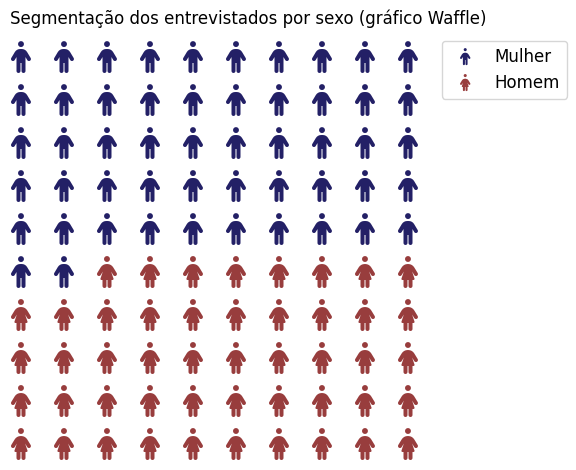

In [28]:
sexo_cores = ['#983D3D', '#232066']
waffle_icons = ['person', 'person-dress']

fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_sexo.nome, values=df_pnad_sexo.total, hole=.65, marker=dict(colors=sexo_cores)))
fig.update_layout(title='Segmentação dos entrevistados por sexo')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    icons=waffle_icons,
    icon_legend =True,
    labels=df_pnad_sexo.nome.values.tolist(),
    values=df_pnad_sexo.total.values.tolist(),
    colors=sexo_cores[::-1],
    title={'label': 'Segmentação dos entrevistados por sexo (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.2) Estado

In [29]:
# preparando o dataframe segmentado
uf_segmentado = df_pnad['uf'].value_counts() # faz a contagem por categoria (uf)
df_pnad_uf = pd.DataFrame({'id': uf_segmentado.index, 'total': uf_segmentado.values})
df_pnad_uf = pd.merge(df_pnad_uf, df_uf, on='id', how='inner')
df_pnad_uf.to_csv('segmentacao-uf.csv', index=False)
df_pnad_uf.head()

,id,total,nome
0,31,103096,Minas Gerais
1,35,98021,São Paulo
2,33,87405,Rio de Janeiro
3,42,70990,Santa Catarina
4,43,66446,Rio Grande do Sul


In [30]:
# plot do gráfico
fig = go.Figure()
fig.add_trace(go.Bar(x=df_pnad_uf.nome.tolist(), y=df_pnad_uf.total.tolist()))
fig.update_layout(title='Segmentação dos entrevistados por UF')
fig.show()

## 3.3) Região metropolitana

In [31]:
# preparando o dataframe segmentado
regiao_metropolitana_segmentado = df_pnad['regiao_metropolitana'].value_counts() # faz a contagem por categoria (região metropolitana)
df_pnad_regiao_metropolitana = pd.DataFrame({'id': regiao_metropolitana_segmentado.index, 'total': regiao_metropolitana_segmentado.values})
df_pnad_regiao_metropolitana = pd.merge(df_pnad_regiao_metropolitana, df_regiao_metropolitana, on='id', how='inner')
df_pnad_regiao_metropolitana.to_csv('segmentacao-regiao-metropolitana.csv', index=False)
df_pnad_regiao_metropolitana.head()

,id,total,nome
0,33,58590,Região Metropolitana de Rio de Janeiro (RJ)
1,35,38160,Região Metropolitana de São Paulo (SP)
2,31,27963,Região Metropolitana de Belo Horizonte (MG)
3,32,22172,Região Metropolitana de Grande Vitória (ES)
4,43,21924,Região Metropolitana de Porto Alegre (RS)


In [32]:
# plot do gráfico
fig = go.Figure()
fig.add_trace(go.Bar(x=df_pnad_regiao_metropolitana.nome.tolist(), y=df_pnad_regiao_metropolitana.total.tolist()))
fig.update_layout(title='Segmentação dos entrevistados por região metropolitana')
fig.show()

## 3.4) Escolaridade

In [33]:
# preparando o dataframe segmentado
escolaridade_segmentado = df_pnad['morador_escolaridade_a005'].value_counts() # faz a contagem por categoria (escolaridade)
df_pnad_escolaridade = pd.DataFrame({'id': escolaridade_segmentado.index, 'total': escolaridade_segmentado.values})
df_pnad_escolaridade = pd.merge(df_pnad_escolaridade, df_escolaridade, on='id', how='inner')
df_pnad_escolaridade.to_csv('segmentacao-escolaridade.csv', index=False)
df_pnad_escolaridade.head()

,id,total,nome
0,2,387986,Fundamental incompleto
1,5,256040,Médio completo
2,1,124035,Sem instrução
3,4,107635,Médio incompleto
4,7,107441,Superior completo


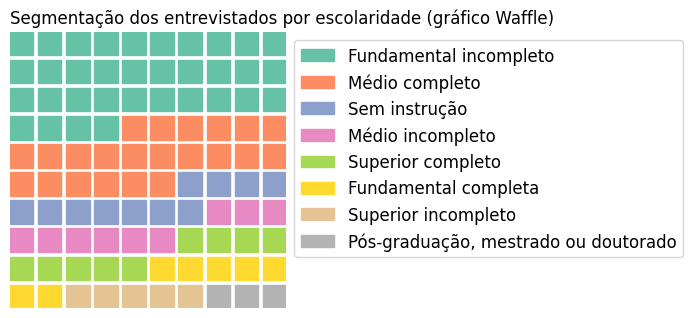

In [34]:
# plot dos gráficos
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_escolaridade.nome.tolist(), values=df_pnad_escolaridade.total.tolist(), hole=.65))
fig.update_layout(title='Segmentação dos entrevistados por escolaridade')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    labels=df_pnad_escolaridade.nome.tolist(),
    values=df_pnad_escolaridade.total.tolist(),
    title={'label': 'Segmentação dos entrevistados por escolaridade (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.5) Idade

In [35]:
# preparando o dataframe segmentado
idade_segmentado = df_pnad['morador_idade_a002'].value_counts(bins=[0, 18, 35, 50, 65, 80, 120], sort=False) # faz a contagem por categoria (faixa de idade)
df_pnad_idade = pd.DataFrame({'nome': idade_segmentado.index, 'total': idade_segmentado.values})
df_pnad_idade.to_csv('segmentacao-idade.csv', index=False)
df_pnad_idade.head()

,nome,total
0,"(-0.001, 18.0]",288774
1,"(18.0, 35.0]",271310
2,"(35.0, 50.0]",251661
3,"(50.0, 65.0]",208806
4,"(65.0, 80.0]",103593


In [36]:
df_pnad_idade.nome.astype(str)

0    (-0.001, 18.0]
1      (18.0, 35.0]
2      (35.0, 50.0]
3      (50.0, 65.0]
4      (65.0, 80.0]
5     (80.0, 120.0]
Name: nome, dtype: object

In [37]:
# plot do gráfico
faixas_etarias = df_pnad_idade.nome.values.astype(str)
populacao = df_pnad_idade.total.values

fig = go.Figure(go.Bar(
            x=populacao,
            y=faixas_etarias,
            orientation='h'))

fig.update_layout(title='Segmentação dos entrevistados por faixa etária',
                  xaxis_title='Número de indivíduos',
                  yaxis_title='Faixas etárias')

fig.show()

## 3.6) Tem plano de sáude?

In [38]:
# preparando o dataframe segmentado
plano_saude_segmentado = df_pnad['tem_plano_saude_b007'].value_counts() # faz a contagem por categoria (plano de saúde)
df_pnad_plano_saude = pd.DataFrame({'id': plano_saude_segmentado.index, 'total': plano_saude_segmentado.values})
df_pnad_plano_saude = pd.merge(df_pnad_plano_saude, df_resposta, on='id', how='inner')
df_pnad_plano_saude.to_csv('segmentacao-plano-saude.csv', index=False)
df_pnad_plano_saude.head()

,id,total,nome
0,2,886199,Não
1,1,260528,Sim
2,9,2470,Ignorado


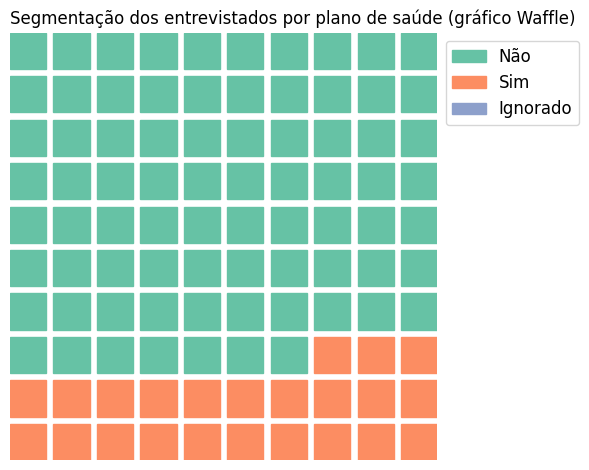

In [39]:
# plot dos gráficos
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_plano_saude.nome, values=df_pnad_plano_saude.total, hole=.65))
fig.update_layout(title='Segmentação dos entrevistados por plano de saúde')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    labels=df_pnad_plano_saude.nome.tolist(),
    values=df_pnad_plano_saude.total.tolist(),
    title={'label': 'Segmentação dos entrevistados por plano de saúde (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.7) Sintomas mais comuns

In [40]:
df_resposta

,id,nome
0,9,Ignorado
1,2,Não
2,3,Não sabe
3,1,Sim


In [41]:
# seleciona apenas colunas com os sintomas
colunas_sintomas = ['sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113']
df_pnad_sintomas = df_pnad[colunas_sintomas]

In [42]:
df_pnad_sintomas.head()

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113
0,2,2,2,2,2,2,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,2,2,2,2,2


In [43]:
# soma o total de casos por sintoma e joga num novo df
df_total_por_sintoma = df_pnad_sintomas.apply(lambda col: (col == 1).sum()) # aqui contamos apenas os registros com valor 1 na coluna
df_total_por_sintoma

sintoma_febre_b0011                      9020
sintoma_tosse_b0012                     15373
sintoma_dor_garganta_b0013              12557
sintoma_dificuldade_respiracao_b0014     4799
sintoma_dor_cabeca_b0015                18960
sintoma_dor_peito_b0016                  3448
sintoma_nausea_b0017                     3958
sintoma_nariz_entupido_b0018            16140
sintoma_fadiga_b0019                     8208
sintoma_dor_olhos_b00110                 3671
sintoma_perda_olfato_b00111              4413
sintoma_dor_muscular_b00112             10883
sintoma_diarreia_b00113                  4301
dtype: int64

In [44]:
# preparando o dataframe segmentado
sintomas_renames_map = {
    'sintoma_febre_b0011': 'Febre',
    'sintoma_tosse_b0012': 'Tosse',
    'sintoma_dor_garganta_b0013': 'Dor de garganta',
    'sintoma_dificuldade_respiracao_b0014': 'Difilcudade de respiração',
    'sintoma_dor_cabeca_b0015': 'Dor de cabeça',
    'sintoma_dor_peito_b0016': 'Dor no peito',
    'sintoma_nausea_b0017': 'Náusea',
    'sintoma_nariz_entupido_b0018': 'Nariz entupido',
    'sintoma_fadiga_b0019': 'Fadiga',
    'sintoma_dor_olhos_b00110': 'Dor nos olhos',
    'sintoma_perda_olfato_b00111': 'Perda de olfato',
    'sintoma_dor_muscular_b00112': 'Dor muscular',
    'sintoma_diarreia_b00113': 'Diárreia'
}
df_total_por_sintoma = pd.DataFrame({'sintoma': df_total_por_sintoma.index.map(sintomas_renames_map), 'total': df_total_por_sintoma.values})
df_total_por_sintoma.to_csv('segmentacao-total-por-sintoma.csv', index=False)
df_total_por_sintoma.head()

,sintoma,total
0,Febre,9020
1,Tosse,15373
2,Dor de garganta,12557
3,Difilcudade de respiração,4799
4,Dor de cabeça,18960


In [45]:
# plot do gráfico
fig = go.Figure(go.Bar(
            x=df_total_por_sintoma.total.values.tolist(),
            y=df_total_por_sintoma.sintoma.values.tolist(),
            orientation='h'))

fig.update_layout(title='Segmentação dos entrevistados por tipo de sintoma',
                  xaxis_title='Número de indivíduos',
                  yaxis_title='Sintoma',
                  height=600)

fig.show()

In [46]:
# vamos preparar um dataframe para utilizar um componente de treemap
total_por_sintoma = df_pnad_sintomas.apply(lambda col: (col == 1).sum()) # aqui contamos apenas os registros com valor 1 na coluna
df_total_sintomas_categorizado = pd.DataFrame({'sintoma': total_por_sintoma.index, 'total': total_por_sintoma.values})

categorias_por_sintoma = {
    'sintoma_febre_b0011': 'Respiratório',
    'sintoma_tosse_b0012': 'Respiratório',
    'sintoma_dor_garganta_b0013': 'Respiratório',
    'sintoma_dificuldade_respiracao_b0014': 'Respiratório',
    'sintoma_dor_cabeca_b0015': 'Geral',
    'sintoma_dor_peito_b0016': 'Geral',
    'sintoma_nausea_b0017': 'Geral',
    'sintoma_nariz_entupido_b0018': 'Respiratório',
    'sintoma_fadiga_b0019': 'Geral',
    'sintoma_dor_olhos_b00110': 'Geral',
    'sintoma_perda_olfato_b00111': 'Respiratório',
    'sintoma_dor_muscular_b00112': 'Geral',
    'sintoma_diarreia_b00113': 'Gastrointestinal'
}

# adiciona as colunas de categoria e porcentagem por sintoma
df_total_sintomas_categorizado['categoria'] = df_total_sintomas_categorizado['sintoma'].map(categorias_por_sintoma)
df_total_sintomas_categorizado['sintoma'] = df_total_sintomas_categorizado['sintoma'].map(sintomas_renames_map)
total_por_categoria = df_total_sintomas_categorizado.groupby('categoria')['total'].sum()
df_total_sintomas_categorizado['porcentagem'] = df_total_sintomas_categorizado.apply(lambda x: (x['total'] / total_por_categoria[x['categoria']]) * 100, axis=1)
df_total_sintomas_categorizado.to_csv('segmentacao-agrupada-total-por-sintoma.csv', index=False)
df_total_sintomas_categorizado

,sintoma,total,categoria,porcentagem
0,Febre,9020,Respiratório,14.477866
1,Tosse,15373,Respiratório,24.674970
2,Dor de garganta,12557,Respiratório,20.155051
3,Difilcudade de respiração,4799,Respiratório,7.702802
4,Dor de cabeça,18960,Geral,38.593063
5,Dor no peito,3448,Geral,7.018401
6,Náusea,3958,Geral,8.056505
7,Nariz entupido,16140,Respiratório,25.906070
8,Fadiga,8208,Geral,16.707377
9,Dor nos olhos,3671,Geral,7.472317


In [47]:
df_total_sintomas_categorizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sintoma      13 non-null     object 
 1   total        13 non-null     int64  
 2   categoria    13 non-null     object 
 3   porcentagem  13 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 544.0+ bytes


In [48]:
import plotly.express as px

fig = px.treemap(
    df_total_sintomas_categorizado,
    path=[px.Constant("Todos"), 'categoria', 'sintoma'],
    values='total',
    custom_data=['total', 'porcentagem'],
  )

fig.update_layout(
    title='Sintomas categorizados',
    margin=dict(t=50, l=25, r=25, b=25),
)

fig.update_traces(
    hovertemplate='<b>%{label}</b><br>Total: %{customdata[0]}<br>Porcentagem: %{customdata[1]:.2f}%',
    texttemplate='<b>%{label}</b><br>%{customdata[1]:.2f}%',
    hoverlabel=dict(
        font=dict(color='white')
    ),
    textposition='middle center'
)

fig.show()

## 3.8) Sintoma + resultado positivo

In [49]:
colunas = colunas_sintomas.copy()
colunas.append('resultado_exame_b009b')

df_sintoma_resultado_positivo = df_pnad[colunas]

# aqui, vamos filtrar todos os registros que apresentaram pelo menos 1 sintoma e tiveram o resultado para Covid19 positivo
filtro_qualquer_sintoma_apresentado = (df_sintoma_resultado_positivo.iloc[:, :-1] == 1).any(axis=1)
filtro_covid_confirmado = (df_sintoma_resultado_positivo['resultado_exame_b009b'] == 1)
df_sintoma_resultado_positivo_filtrado = df_sintoma_resultado_positivo[filtro_qualquer_sintoma_apresentado & filtro_covid_confirmado]
df_sintoma_resultado_positivo_filtrado.head()

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,resultado_exame_b009b
6657,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8894,2,2,2,2,2,2,2,2,2,2,2,1,2,1
9173,1,1,2,1,1,1,2,2,1,2,9,9,9,1
11140,1,1,1,2,1,1,2,2,2,2,2,2,2,1
16340,2,1,1,1,1,2,1,1,1,2,1,1,1,1


In [50]:
df_sintoma_resultado_positivo_filtrado

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,resultado_exame_b009b
6657,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8894,2,2,2,2,2,2,2,2,2,2,2,1,2,1
9173,1,1,2,1,1,1,2,2,1,2,9,9,9,1
11140,1,1,1,2,1,1,2,2,2,2,2,2,2,1
16340,2,1,1,1,1,2,1,1,1,2,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145865,1,2,2,2,1,2,2,2,2,9,1,1,9,1
1146341,2,2,2,2,2,2,2,2,1,2,2,2,2,1
1147951,2,2,2,1,2,2,1,1,1,1,1,1,2,1
1148313,1,1,1,2,2,2,2,2,2,9,1,9,9,1


## 3.9) Escolaridade + resultado positivo

In [51]:
df_pnad.columns

Index(['uf', 'capital', 'regiao_metropolitana', 'semana_mes_v1012',
       'mes_v1013', 'situacao_domicilio_v1022', 'tipo_area_v1023',
       'morador_idade_a002', 'morador_sexo_a003', 'morador_raca_a004',
       'morador_escolaridade_a005', 'sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113',
       'compareceu_estabelecimento_saude_b002', 'sedado_entubado_b006',
       'tem_plano_saude_b007', 'resultado_exame_b009b',
       'medida_restricao_contato_b011', 'trabalhou_remoto_c013',
       'recebeu_auxilio_emergencial_d0051'],
      dtype='object')

In [52]:
df_escolaridade

,id,nome
0,3,Fundamental completa
1,7,Superior completo
2,8,"Pós-graduação, mestrado ou doutorado"
3,5,Médio completo
4,1,Sem instrução
5,2,Fundamental incompleto
6,4,Médio incompleto
7,6,Superior incompleto


In [53]:
# preparando o dataframe segmentado
colunas = ['morador_escolaridade_a005', 'resultado_exame_b009b']

df_escolaridade_covid = df_pnad[df_pnad['resultado_exame_b009b'] == 1]
df_escolaridade_covid = df_escolaridade_covid[colunas].groupby('morador_escolaridade_a005').agg(contagem=('resultado_exame_b009b', 'count'))
df_escolaridade_covid = pd.merge(df_escolaridade_covid, df_escolaridade, left_on='morador_escolaridade_a005', right_on='id', how='inner')
df_escolaridade_covid.to_csv('segmentacao-escolaridade-x-casos-positivos.csv', index=False)
df_escolaridade_covid

,contagem,id,nome
0,502,1,Sem instrução
1,2279,2,Fundamental incompleto
2,827,3,Fundamental completa
3,1021,4,Médio incompleto
4,4269,5,Médio completo
5,1452,6,Superior incompleto
6,3133,7,Superior completo
7,967,8,"Pós-graduação, mestrado ou doutorado"


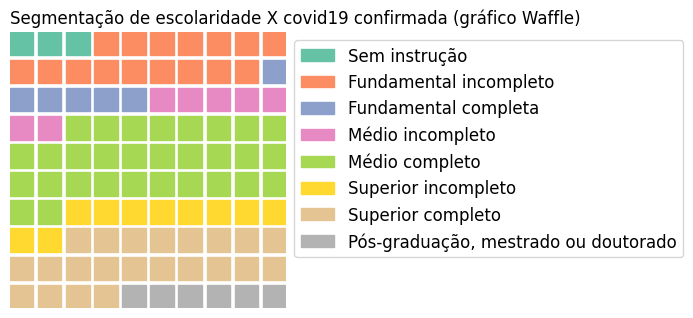

In [54]:
# donut
fig = go.Figure()
fig.add_trace(
      go.Pie(
          labels=df_escolaridade_covid.nome,
          values=df_escolaridade_covid.contagem,
          hole=.65
      )
    )
fig.update_layout(title='Segmentação de escolaridade X covid19 confirmada')
fig.show()

# waffle
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    labels=df_escolaridade_covid.nome.tolist(),
    values=df_escolaridade_covid.contagem.tolist(),
    title={'label': 'Segmentação de escolaridade X covid19 confirmada (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.10) Plano de saúde + resultado positivo

In [55]:
# preparando o dataframe segmentado
colunas = ['tem_plano_saude_b007', 'resultado_exame_b009b']

df_plano_saude_covid = df_pnad[df_pnad['resultado_exame_b009b'] == 1]
df_plano_saude_covid = df_plano_saude_covid[colunas].groupby('tem_plano_saude_b007').agg(contagem=('resultado_exame_b009b', 'count'))
df_plano_saude_covid = pd.merge(df_plano_saude_covid, df_resposta, left_on='tem_plano_saude_b007', right_on='id', how='inner')
df_plano_saude_covid.to_csv('segmentacao-plano-saude-x-casos-positivos.csv', index=False)
df_plano_saude_covid

,contagem,id,nome
0,6714,1,Sim
1,7722,2,Não
2,14,9,Ignorado


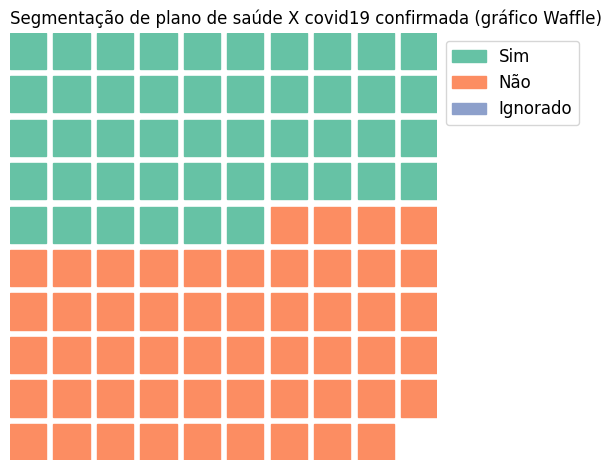

In [56]:
# donut
fig = go.Figure()
fig.add_trace(
      go.Pie(
          labels=df_plano_saude_covid.nome,
          values=df_plano_saude_covid.contagem,
          hole=.65
      )
    )
fig.update_layout(title='Segmentação de plano de saúde X covid19 confirmada')
fig.show()

# waffle
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    labels=df_plano_saude_covid.nome.tolist(),
    values=df_plano_saude_covid.contagem.tolist(),
    title={'label': 'Segmentação de plano de saúde X covid19 confirmada (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)

plt.show()

## 3.11) Infectados mês à mês

In [57]:
# aqui decidi executar a query dentro do próprio BigQuery
# portanto, simplesmente rodo o job que guarda o histórico de execução da query
# importante: vale notar que tabela temporária criada pelo job é reciclada após 24 horas
# sendo necessário executar novamente a query original e gerar um novo job id (não parece ser muito prático)
meses_map = {
    9: 'Setembro',
    10: 'Outubro',
    11: 'Novembro'
}

query_job = client.get_job('bquxjob_9b6a278_18df318f73f')
df_casos_positivos_mes_a_mes = query_job.result().to_dataframe()
df_casos_positivos_mes_a_mes['mes_label'] = df_casos_positivos_mes_a_mes.mes.map(meses_map)
df_casos_positivos_mes_a_mes.to_csv('evolucao-casos-positivos-mes-a-mes.csv', index=False)
df_casos_positivos_mes_a_mes

NotFound: 404 GET https://bigquery.googleapis.com/bigquery/v2/projects/silver-axon-412605/queries/bquxjob_9b6a278_18df318f73f?maxResults=0&location=US&prettyPrint=false: Not found: Table silver-axon-412605:_5567a761d472f120692bd53e0a1692793da50622.anonb766090739170c79bdd94523ac75c1515b601bc087768ef7dc3659ad06cc9d38

Location: US
Job ID: bquxjob_9b6a278_18df318f73f


In [ ]:
# plot da evolução dos últimos 3 meses
fig = go.Figure(
    go.Bar(
      x=df_casos_positivos_mes_a_mes.mes_label,
      y=df_casos_positivos_mes_a_mes.total,
      name='Meses'
    )
)

fig.add_trace(
    go.Scatter(
        x=df_casos_positivos_mes_a_mes.mes_label,
        y=df_casos_positivos_mes_a_mes.total,
        mode='lines',
        name='Tendência'
    )
)

fig.update_layout(title='Evolução dos casos positivos nos últimos 3 meses',
                  xaxis_title='Mês',
                  yaxis_title='Número de casos positivos')

fig.show()

## 3.12) Infectados por estado mês à mês

In [58]:
query_job = client.get_job('bquxjob_1afdbba6_18df3194685')
df_casos_positivos_mes_a_mes_por_uf = query_job.result().to_dataframe()
df_casos_positivos_mes_a_mes_por_uf.to_csv('evolucao-casos-positivos-mes-a-mes-por-uf.csv', index=False)
df_casos_positivos_mes_a_mes_por_uf

NotFound: 404 GET https://bigquery.googleapis.com/bigquery/v2/projects/silver-axon-412605/queries/bquxjob_1afdbba6_18df3194685?maxResults=0&location=US&prettyPrint=false: Not found: Table silver-axon-412605:_5567a761d472f120692bd53e0a1692793da50622.anona42a19a9132e8b0fe3945b061b505b5b2091ec6ac68118526a2978d6e0cbe83a

Location: US
Job ID: bquxjob_1afdbba6_18df3194685


In [ ]:
num_colors = len(df_casos_positivos_mes_a_mes_por_uf['estado'].unique()) # quantidade de cores únicas
colors = [f"hsl({h}, 50%, 50%)" for h in range(0, 320, int(320 / num_colors))] # cor final

# plottando o gráfico
fig = go.Figure()

for i, state in enumerate(df_casos_positivos_mes_a_mes_por_uf['estado'].unique()):
    state_data = df_casos_positivos_mes_a_mes_por_uf[df_casos_positivos_mes_a_mes_por_uf['estado'] == state]
    fig.add_trace(go.Bar(x=state_data['mes'], y=state_data['total_casos_confirmados'], name=state, marker_color=colors[i]))

fig.update_layout(title='Evolução dos casos positivos nos últimos 3 meses, agrupado por UF',
                  xaxis=dict(title='Mês'),
                  yaxis=dict(title='Total'),
                  barmode='group')

fig.show()

# 4) Machine Learning

In [59]:
colunas_renames_map = {
    'uf': 'Estado',
    'capital': 'Capital',
    'regiao_metropolitana': 'Região metropolitana',
    'semana_mes_v1012': 'Semana do mês',
    'mes_v1013': 'Mês',
    'situacao_domicilio_v1022': 'Situação do domícilio',
    'tipo_area_v1023': 'Tipo da área',
    'morador_idade_a002': 'Idade',
    'morador_sexo_a003': 'Sexo',
    'morador_raca_a004': 'Raça',
    'morador_escolaridade_a005': 'Escolaridade',
    'sintoma_febre_b0011': 'Sintoma: Febre',
    'sintoma_tosse_b0012': 'Sintoma:Tosse',
    'sintoma_dor_garganta_b0013': 'Sintoma:Dor de garganta',
    'sintoma_dificuldade_respiracao_b0014': 'Sintoma:Difilcudade de respiração',
    'sintoma_dor_cabeca_b0015': 'Sintoma:Dor de cabeça',
    'sintoma_dor_peito_b0016': 'Sintoma:Dor no peito',
    'sintoma_nausea_b0017': 'Sintoma:Náusea',
    'sintoma_nariz_entupido_b0018': 'Sintoma:Nariz entupido',
    'sintoma_fadiga_b0019': 'Sintoma:Fadiga',
    'sintoma_dor_olhos_b00110': 'Sintoma:Dor nos olhos',
    'sintoma_perda_olfato_b00111': 'Sintoma:Perda de olfato',
    'sintoma_dor_muscular_b00112': 'Sintoma:Dor muscular',
    'sintoma_diarreia_b00113': 'Sintoma:Diárreia',
    'compareceu_estabelecimento_saude_b002': 'Compareceu estabelecimento',
    'sedado_entubado_b006': 'Foi sedado/entubado',
    'tem_plano_saude_b007': 'Plano de saúde',
    'resultado_exame_b009b': 'Resulado do exame',
    'medida_restricao_contato_b011': 'Medida de restrição',
    'trabalhou_remoto_c013': 'Trabalhou remotamente',
    'recebeu_auxilio_emergencial_d0051': 'Recebeu auxílio'
}

matriz_correlacao = df_pnad.rename(columns=colunas_renames_map).corr()
matriz_correlacao.to_csv('correlacao.csv', index=False)
matriz_correlacao

,Estado,Capital,Região metropolitana,Semana do mês,Mês,Situação do domícilio,Tipo da área,Idade,Sexo,Raça,...,Sintoma:Perda de olfato,Sintoma:Dor muscular,Sintoma:Diárreia,Compareceu estabelecimento,Foi sedado/entubado,Plano de saúde,Resulado do exame,Medida de restrição,Trabalhou remotamente,Recebeu auxílio
Estado,1.000000,1.000000,0.999973,-0.003434,0.000068,-0.096999,0.010940,0.075270,0.001069,-0.266116,...,-0.002213,-0.003438,-0.001586,-0.048081,-0.046356,-0.131018,0.015275,0.001808,-0.177951,0.188540
Capital,1.000000,1.000000,1.000000,0.001370,-0.000066,0.040197,NaN,0.077778,0.001835,-0.217426,...,-0.005429,-0.006489,-0.005065,-0.024013,-0.094299,-0.124845,0.031850,0.025717,-0.229478,0.152745
Região metropolitana,0.999973,1.000000,1.000000,-0.001828,0.001288,-0.052147,0.054983,0.064419,-0.003962,-0.252005,...,-0.006312,-0.008249,-0.005673,-0.038097,-0.090114,-0.107201,0.005355,0.014996,-0.143467,0.148751
Semana do mês,-0.003434,0.001370,-0.001828,1.000000,-0.003796,-0.001212,-0.002909,0.003774,0.000169,0.001253,...,-0.005741,-0.005501,-0.005494,-0.019611,0.044825,-0.002609,0.006245,-0.014740,0.005347,-0.000789
Mês,0.000068,-0.000066,0.001288,-0.003796,1.000000,-0.003053,-0.005087,0.003910,0.000675,-0.000290,...,-0.006284,-0.005843,-0.006271,-0.036417,0.060026,-0.009530,-0.001228,-0.077593,0.011517,0.025904
Situação do domícilio,-0.096999,0.040197,-0.052147,-0.001212,-0.003053,1.000000,0.345788,-0.019772,-0.034067,0.073349,...,-0.012170,-0.012045,-0.012768,0.050434,-0.008171,0.149118,0.008591,0.044070,0.219366,-0.127359
Tipo da área,0.010940,NaN,0.054983,-0.002909,-0.005087,0.345788,1.000000,-0.016657,-0.019897,-0.000682,...,-0.019374,-0.019513,-0.020146,0.019623,-0.003767,0.141320,0.008551,0.001985,0.231811,-0.068234
Idade,0.075270,0.077778,0.064419,0.003774,0.003910,-0.019772,-0.016657,1.000000,0.048482,-0.079444,...,-0.007140,-0.015287,-0.005904,0.031547,-0.071187,-0.050914,-0.007097,-0.057867,-0.030003,0.207607
Sexo,0.001069,0.001835,-0.003962,0.000169,0.000675,-0.034067,-0.019897,0.048482,1.000000,-0.013371,...,-0.001014,-0.002734,-0.000684,-0.011379,-0.055628,-0.014539,0.011546,0.085277,-0.364944,0.009043
Raça,-0.266116,-0.217426,-0.252005,0.001253,-0.000290,0.073349,-0.000682,-0.079444,-0.013371,1.000000,...,0.004605,0.004191,0.004806,0.011422,-0.012796,0.145641,-0.023387,-0.003592,0.214870,-0.172679


In [60]:
# plot do heatmap (correlação)
fig = go.Figure(data=go.Heatmap(z=matriz_correlacao.values[::-1],
                                 x=matriz_correlacao.columns,
                                 y=matriz_correlacao.columns[::-1],
                                 colorbar=dict(title='Correlação'),
                                 colorscale='Viridis',
                                 xgap=1,
                                 ygap=1))

fig.update_layout(title='Matriz de correlação', height=1200)
fig.update_layout(xaxis_side="top", xaxis=dict(tickangle=-45))
fig.show()

## 4.1) Criando um modelo de previsão para identificar se um entrevistado está com Covid19 ou não, utilizando o algoritmo de Ensemble XGBoost

### 4.1.1) Feature Engineering

In [61]:
df_pnad.columns

Index(['uf', 'capital', 'regiao_metropolitana', 'semana_mes_v1012',
       'mes_v1013', 'situacao_domicilio_v1022', 'tipo_area_v1023',
       'morador_idade_a002', 'morador_sexo_a003', 'morador_raca_a004',
       'morador_escolaridade_a005', 'sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113',
       'compareceu_estabelecimento_saude_b002', 'sedado_entubado_b006',
       'tem_plano_saude_b007', 'resultado_exame_b009b',
       'medida_restricao_contato_b011', 'trabalhou_remoto_c013',
       'recebeu_auxilio_emergencial_d0051'],
      dtype='object')

In [62]:
pnad_feature_columns = ['sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113',
       'compareceu_estabelecimento_saude_b002', 'sedado_entubado_b006']

pnad_target_column = ['resultado_exame_b009b']

In [96]:
from sklearn.model_selection import train_test_split

df_ml = df_pnad.copy()

# preenche valores <NA> com 0
df_ml.fillna(0, inplace=True)

# obtém uma amostra de 10000 registros
df_ml = df_ml.sample(n=10000, random_state=777)

# divide as colunas da amostra em X (features) e Y (target)
x = df_ml[pnad_feature_columns]
y = df_ml[pnad_target_column]

In [97]:
x.values

array([[2, 2, 2, ..., 2, 0, 0],
       [2, 2, 2, ..., 2, 0, 0],
       [2, 2, 2, ..., 2, 0, 0],
       ...,
       [2, 2, 2, ..., 2, 0, 0],
       [2, 2, 2, ..., 2, 0, 0],
       [2, 2, 2, ..., 2, 0, 0]], dtype=object)

In [98]:
y.values

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [105]:
# faz o split da amostra
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)

In [106]:
print(f'shape x_train: {x_train.shape}')
print(f'shape x_test: {x_test.shape}')
print(f'shape y_train: {y_train.shape}')
print(f'shape y_test: {y_test.shape}')

shape x_train: (8000, 15)
shape x_test: (2000, 15)
shape y_train: (8000, 1)
shape y_test: (2000, 1)


In [108]:
x_train.head()

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,compareceu_estabelecimento_saude_b002,sedado_entubado_b006
612677,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0
44339,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0
959163,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0
483794,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0
857000,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0


In [109]:
y_train.rename(columns={'resultado_exame_b009b': 'y'}, inplace=True)

In [110]:
y_train.head()

,y
612677,0
44339,0
959163,0
483794,0
857000,0


In [111]:
y_train['y']

612677    0
44339     0
959163    0
483794    0
857000    0
         ..
456241    0
997569    0
394635    0
137433    0
477211    0
Name: y, Length: 8000, dtype: Int64

In [112]:
y_train['y'].values

<IntegerArray>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 ...
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 8000, dtype: Int64

In [113]:
y_train['y'].ravel()

<IntegerArray>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 ...
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 8000, dtype: Int64

### 4.1.2) Obtendo os melhores parâmetros do XGBoost

In [114]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [116]:
def melhores_hiperparamentros_xgb(x_train, y_train):
    param_grid = {
      'learning_rate':[0.01, 0.05, 0.2],
      'n_estimators':[50, 100, 200],
      'max_depth': [1, 2, 5, 8]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
      GradientBoostingClassifier(),
      param_grid = param_grid,
      scoring = 'f1',
      cv = cv,
      n_jobs= -1
    )

    # seleciona os melhores hiperparâmetros com base nos dados de treino
    grid.fit(x_train, y_train)
    xgb_params = grid.best_params_

    print("Melhores hiperparâmetros para XGB:", xgb_params)

    return xgb_params

In [117]:
# DESATIVADO PELO TEMPO DEMANDADO PARA EXECUÇÃO
# params = melhores_hiperparamentros_xgb(x_train, y_train)
# Melhores hiperparâmetros para XGB: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}

### 4.1.3) Execução do XGB com hiperparâmetros default

In [118]:
kfold = KFold(n_splits=30, shuffle=True)
xgb1 = GradientBoostingClassifier()
xgb1.fit(x_train, y_train['y'])
xgb1_result = cross_val_score(xgb1, x_train, y_train, cv = kfold)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:


In [119]:
xgb1_result.mean()

0.9510015675893854

In [120]:
xgb1_previsoes = xgb1.predict(x_test)
xgb1_acuracia = accuracy_score(y_true = y_test, y_pred = xgb1_previsoes) * 100
xgb1_acuracia

96.3

### 4.1.3) Execução do XGB com hiperparâmetros sugeridos

In [121]:
kfold = KFold(n_splits=30, shuffle=True)
xgb2 = GradientBoostingClassifier(learning_rate=0.01, max_depth=1, n_estimators=50)
xgb2.fit(x_train, y_train['y'])
xgb2_result = cross_val_score(xgb2, x_train, y_train, cv = kfold)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:


In [122]:
xgb2_result.mean()

0.9535054865628492

In [123]:
xgb2_previsoes = xgb2.predict(x_test)
xgb2_acuracia = accuracy_score(y_true = y_test, y_pred = xgb2_previsoes) * 100
xgb2_acuracia

96.5

In [143]:
print(f'XGB1 (parâmetros default) = {xgb1_acuracia:.2f}% VS XGB2 (parâmetros sugeridos) = {xgb2_acuracia:.2f}%')

XGB1 (parâmetros default) = 96.30% VS XGB2 (parâmetros sugeridos) = 96.50%


### 4.1.4) Exportando os modelos via joblib para uso posterior

In [125]:
import joblib

In [144]:
joblib.dump(xgb1, 'xgb-default.pkl')
joblib.dump(xgb2, 'xgb-sugeridos.pkl')

['xgb-sugeridos.pkl']

In [150]:
# importante salvar sem o index dos dfs
x_test.to_csv('xgb_x_test.csv', index=False)
y_test.to_csv('xgb_y_test.csv', index=False)

### 4.1.5) Testando a exportação dos modelos

In [140]:
def recarrega_modelo_xgb(file: str):
  xgb_recarregado = joblib.load(file)
  xgb_recarregado_previsoes = xgb_recarregado.predict(x_test)
  xgb_recarregado_acuracia = accuracy_score(y_true = y_test, y_pred = xgb_recarregado_previsoes) * 100

  print(f'{xgb_recarregado_acuracia:.2f}%')

In [141]:
recarrega_modelo_xgb('xgb-default.pkl')

96.30%


In [142]:
recarrega_modelo_xgb('xgb-sugeridos.pkl')

96.50%


In [149]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


## 4.2) Criando um modelo de clusterização para identificar como os entrevistados estão agrupados entre si, utilizando KMeans e DBSCAN

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score

## 4.2.1) KMeans

In [ ]:
k_elbows = list(range(1, 10))
sse = []

# Roda o K-means para cada k fornecido
for i in k_elbows:
    kmeans = KMeans(n_clusters=i, random_state=777)
    kmeans.fit(x)
    sse.append(kmeans.inertia_) #calculo do erro do k-mens (mudar o centroide dos dados)

plt.rcParams['figure.figsize'] = (10, 5)
# Plota o gráfico com a soma dos erros quadraticos
plt.plot(k_elbows, sse, '-o')
plt.xlabel(r'Número de clusters')
plt.ylabel('Inércia')
plt.show()

Segundo o método Elbow, podemos definir entre 5 ou 6 centroides para o KMeans

In [ ]:
# Definindo o modelo de clusterizacao. K-MEANS com 5 clusters
kmeans = KMeans(n_clusters=5,random_state=777)

#Implementando o K-Means nos dados:
kmeans.fit(x)

#Salvando os centroides de cada cluster
centroides = kmeans.cluster_centers_

#Salvando os labels dos clusters para cada exemplo
kmeans_labels = kmeans.predict(x)

In [ ]:
# utilizando PCA para tentar reduzir a dimensionalidade dos dados
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)

### TODO: CORRIGIR ESSE PLOT, O PCA QUEBROU MAIS AINDA RS

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, alpha=0.5, cmap='rainbow')
plt.xlabel('Salario Anual')
plt.ylabel('Pontuação de gastos')
# plotando os centroides
plt.scatter(centroides[:, 0], centroides[:, 1], c='black', marker='X', s=200, alpha=0.5)
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

In [ ]:
# validar com silhouette_score e adjusted_rand_score
# metodo elbow para calcular quantidade de centroides

## 4.2.2) DBSCAN

### TODO: CORRIGIR ESSE PLOT, O PCA QUEBROU MAIS AINDA RS

In [ ]:
#Criando o modelo:
dbscan = DBSCAN(eps=10, min_samples=8)
#Ajustando aos dados
dbscan.fit(x)

dbscan_labels = dbscan.labels_
dbscan_labels

In [ ]:
#Plotando o grafico:
plt.scatter(x, x, c=dbscan_labels, alpha=0.5, cmap='rainbow')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

## 4.2.3) Avaliando os resultados

### TODO: pq deu um valor tao baixo?

In [ ]:
# comparando os clusters entre cada método
adjusted_rand_score(kmeans_labels,dbscan_labels)

In [ ]:
# clusters mais ou menos separados
silhouette_score(x, kmeans_labels)

In [ ]:
# clusters relativamente bem separados
silhouette_score(x, dbscan_labels)

## 4.2.4) Exportando os modelos via joblib